In [181]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

In [131]:
df = pd.read_csv('car_price_prediction.csv')

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

В датасете относительно много данных и нет значений nan.
Непонятные колонки: Levy.
Стоит посмотреть колонки типа object на наличие "пропусков", бинарных или числовых типов.

In [133]:
df["Levy"].unique()

array(['1399', '1018', '-', '862', '446', '891', '761', '751', '394',
       '1053', '1055', '1079', '810', '2386', '1850', '531', '586',
       '1249', '2455', '583', '1537', '1288', '915', '1750', '707',
       '1077', '1486', '1091', '650', '382', '1436', '1194', '503',
       '1017', '1104', '639', '629', '919', '781', '530', '640', '765',
       '777', '779', '934', '769', '645', '1185', '1324', '830', '1187',
       '1111', '760', '642', '1604', '1095', '966', '473', '1138', '1811',
       '988', '917', '1156', '687', '11714', '836', '1347', '2866',
       '1646', '259', '609', '697', '585', '475', '690', '308', '1823',
       '1361', '1273', '924', '584', '2078', '831', '1172', '893', '1872',
       '1885', '1266', '447', '2148', '1730', '730', '289', '502', '333',
       '1325', '247', '879', '1342', '1327', '1598', '1514', '1058',
       '738', '1935', '481', '1522', '1282', '456', '880', '900', '798',
       '1277', '442', '1051', '790', '1292', '1047', '528', '1211',
       

Levy перевод - сбор. Похоже на какой-то налог.
Учитывая что всего 9 уникальных значений, то это дискретная величина.

In [134]:
df["Levy"].value_counts()

Levy
-       5819
765      486
891      461
639      410
640      405
        ... 
3156       1
2908       1
1279       1
1719       1
1901       1
Name: count, Length: 559, dtype: int64

In [135]:
df["Levy"] = df["Levy"].replace("-", 0)
df = df.astype({"Levy": "int32"})

По информации с kaggle: "Tax of importing and exporting the cars."
Так же указано, что не определена валюта и смысл для "-".

Принял "-", как 0 и изменил тип колонки на числовой.

In [136]:
df["Manufacturer"].value_counts()

Manufacturer
HYUNDAI          3769
TOYOTA           3662
MERCEDES-BENZ    2076
FORD             1111
CHEVROLET        1069
                 ... 
TESLA               1
PONTIAC             1
SATURN              1
ASTON MARTIN        1
GREATWALL           1
Name: count, Length: 65, dtype: int64

In [137]:
df[df["Manufacturer"] == "სხვა"]

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2358,45779593,25089,0,სხვა,IVECO DAYLY,2007,Microbus,No,Diesel,2.3 Turbo,328000 km,4.0,Manual,Rear,04-May,Left wheel,White,1
4792,39223518,9408,0,სხვა,GONOW,2005,Jeep,Yes,Petrol,2.3,102000 km,4.0,Manual,Rear,04-May,Left wheel,Silver,2


Есть необычное значение "სხვა" в колонке Manufacturer.
Google определил как Грузинский язык. Перевод на английский other, что подходит по смыслу.
Какой шанс, что автор датасета Грузин?)

Удаляю строчки с სხვა в Manufacturer.

In [138]:
df = df[df["Manufacturer"] != "სხვა"]

Заменяю бинарные классификации колонками булевых типов:

In [139]:
df["Leather interior"] = pd.get_dummies(df["Leather interior"], drop_first=True)
df["Right_hand"] = pd.get_dummies(df["Wheel"], drop_first=True)
df = df.drop(["Wheel"], axis=1)

In [140]:
# конвертирую float в int
df = df.astype({"Cylinders": "int32"})

Функции для конвертации колонок в числовые типы: Mileage, Engine volume.
Функция для колонки Turbo.

In [141]:
def mileage_to_int(x: str) -> int:
    return int(x.replace(" km", ""))
df["Mileage"] = df["Mileage"].apply(mileage_to_int)


In [142]:
def has_turbo(x: str) -> bool:
    return "Turbo" in x
df["Turbo"] = df["Engine volume"].apply(has_turbo)

In [143]:
def engine_volume_to_float(x: str) -> float:
    return float(x.replace(" Turbo", ""))
df["Engine volume"] = df["Engine volume"].apply(engine_volume_to_float)

Колонки: Doors, Drive wheels, Gear box type привел к числовому формату.
Изменил имена колонок на более понятные и удалил Doors, Drive wheels, Gear.

In [144]:
df = pd.concat([
    df,
    pd.get_dummies(df["Doors"], drop_first=True),
    pd.get_dummies(df["Drive wheels"], drop_first=True),
    pd.get_dummies(df["Gear box type"], drop_first=True),
], axis=1)
df = df.rename(columns={"04-May": "4 doors", ">5": ">5 doors"})
# удаляю модель, поскольку она объясняется другими признаками
df = df.drop(["Doors", "Drive wheels", "Gear box type", "Model"], axis=1)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Price", "ID"], axis=1), df["Price"], test_size=0.2, random_state=144, shuffle=True)

In [146]:
encoder_mm = LeaveOneOutEncoder()
X_train['Manufacturer'] = encoder_mm.fit_transform(X_train['Manufacturer'], y_train)

In [147]:
encoder_col = LeaveOneOutEncoder()
X_train['Color'] = encoder_col.fit_transform(X_train['Color'], y_train)

In [148]:
encoder_ft = LeaveOneOutEncoder()
X_train['Fuel type'] = encoder_ft.fit_transform(X_train['Fuel type'], y_train)

In [149]:
encoder_cat = LeaveOneOutEncoder()
X_train['Category'] = encoder_cat.fit_transform(X_train['Category'], y_train)

In [150]:
m = LinearRegression()
m.fit(X_train, y_train)

LinearRegression()

In [151]:
X_test['Manufacturer'] = encoder_mm.transform(X_test['Manufacturer'], y_test)
X_test['Color'] = encoder_col.transform(X_test['Color'], y_test)
X_test['Fuel type'] = encoder_ft.fit_transform(X_test['Fuel type'], y_test)
X_test['Category'] = encoder_cat.fit_transform(X_test['Category'], y_test)

In [152]:
prediction = m.predict(X_test)

In [153]:
(
    mean_squared_error(y_test, prediction),
    mean_absolute_error(y_test, prediction),
    r2_score(y_test, prediction),
)

(379111236.6137493, 12951.482086170623, -0.1214373328422691)

Можно с уверенностью сказать, что цену модель не объясняет.
Стоит поработать с выбросами в колонке цены, поскольку mse очень высокое.

In [154]:
df["Price"].describe().T

count    1.923500e+04
mean     1.855606e+04
std      1.905912e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.206900e+04
max      2.630750e+07
Name: Price, dtype: float64

In [155]:
df["Price"].sort_values(ascending=True).tail(20)

2912       172486
2768       172486
6468       172486
9248       172486
4722       175622
13328      193184
1145       194438
7353       216391
2283       219527
7283       228935
15283      250574
5840       254024
10759      260296
7749       288521
14839      297930
9367       297930
5008       308906
1225       627220
8541       872946
16983    26307500
Name: Price, dtype: int64

Смотрим количество машин в группах по 100к

In [156]:
(
    len(df[df.Price <= 100000]),
    len(df[(df.Price > 100000) & (df.Price <= 200000)]),
    len(df[df.Price > 200000]),
)

(19122, 100, 13)

In [157]:
#Для начала отбросим все свыше 100к
df = df[(df.Price < 100000)]

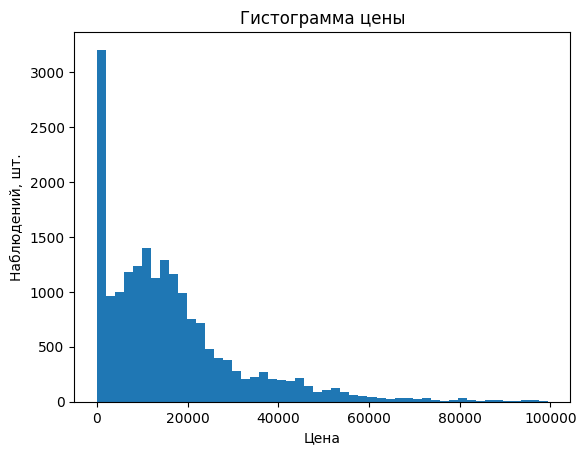

In [158]:
plt.title("Гистограмма цены")
plt.xlabel("Цена")
plt.ylabel("Наблюдений, шт.")
plt.hist(df["Price"], bins=50);

In [159]:
df["Price"].sort_values(ascending=False).tail(20)

12917    6
18575    6
5344     6
5890     3
8993     3
17596    3
11636    3
753      3
14492    3
4776     3
221      3
14642    3
4958     3
10885    3
13419    3
15347    3
7276     3
9730     3
16992    1
7815     1
Name: Price, dtype: int64

In [160]:
(
    len(df[df.Price <= 1000]),
    len(df[(df.Price > 1000) & (df.Price <= 2000)]),
    len(df[(df.Price > 2000) & (df.Price <= 3000)]),
    len(df[(df.Price > 3000) & (df.Price <= 4000)]),
    len(df[(df.Price > 4000) & (df.Price <= 5000)]),
    len(df[(df.Price > 5000) & (df.Price <= 6000)]),
    len(df[(df.Price > 6000) & (df.Price <= 7000)]),
    len(df[(df.Price > 7000) & (df.Price <= 8000)]),
    len(df[(df.Price > 8000) & (df.Price <= 9000)]),
    len(df[(df.Price > 10000) & (df.Price <= 11000)]),
)

(2585, 627, 436, 526, 452, 544, 540, 692, 569, 791)

Значения меньше 1000 являются выбросом с количественной точки зрения.
Может создать отдельную модель для значений меньше 1000?
Посмотрим эту тысячу по сотням.

In [161]:
(
    len(df[df.Price <= 100]),
    len(df[(df.Price > 100) & (df.Price <= 200)]),
    len(df[(df.Price > 200) & (df.Price <= 300)]),
    len(df[(df.Price > 300) & (df.Price <= 400)]),
    len(df[(df.Price > 400) & (df.Price <= 500)]),
    len(df[(df.Price > 500) & (df.Price <= 600)]),
    len(df[(df.Price > 600) & (df.Price <= 700)]),
    len(df[(df.Price > 700) & (df.Price <= 800)]),
    len(df[(df.Price > 800) & (df.Price <= 900)]),
    len(df[(df.Price > 1000) & (df.Price <= 1100)]),
)

(381, 279, 240, 487, 278, 185, 196, 278, 122, 125)

In [162]:
#Аналогично отбросим все ниже 1000
df = df[(df.Price >= 1000)]

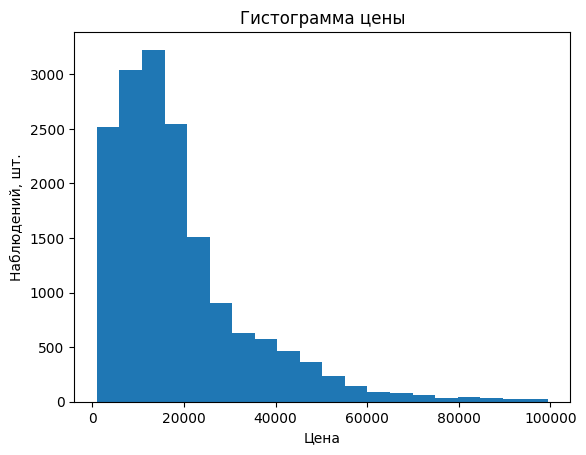

In [163]:
plt.title("Гистограмма цены")
plt.xlabel("Цена")
plt.ylabel("Наблюдений, шт.")
plt.hist(df["Price"], bins=20);

Похожие распределения: Negative Binomial

*Ремарка: если увеличивать количество бинов, то похожесть уходит, много локальных пиков.

In [164]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Price", "ID"], axis=1), df["Price"], test_size=0.2, random_state=144, shuffle=True)

In [165]:
encoder_mm = LeaveOneOutEncoder()
X_train['Manufacturer'] = encoder_mm.fit_transform(X_train['Manufacturer'], y_train)

In [166]:
encoder_col = LeaveOneOutEncoder()
X_train['Color'] = encoder_col.fit_transform(X_train['Color'], y_train)

In [167]:
encoder_ft = LeaveOneOutEncoder()
X_train['Fuel type'] = encoder_ft.fit_transform(X_train['Fuel type'], y_train)

In [168]:
encoder_cat = LeaveOneOutEncoder()
X_train['Category'] = encoder_cat.fit_transform(X_train['Category'], y_train)

In [169]:
m = LinearRegression()
m.fit(X_train, y_train)

LinearRegression()

In [170]:
X_test['Manufacturer'] = encoder_mm.transform(X_test['Manufacturer'], y_test)
X_test['Color'] = encoder_col.transform(X_test['Color'], y_test)
X_test['Fuel type'] = encoder_ft.fit_transform(X_test['Fuel type'], y_test)
X_test['Category'] = encoder_cat.fit_transform(X_test['Category'], y_test)

In [171]:
prediction = m.predict(X_test)

In [172]:
(
    mean_squared_error(y_test, prediction),
    mean_absolute_error(y_test, prediction),
    r2_score(y_test, prediction),
)

(149234213.00918543, 8645.064757976801, 0.3599183626933473)

Метрика выросла, но в большинстве случаев мы все-таки ни как не объясняем цену.

Попробуем посмотреть зависимости признаков с целевым.

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16548 entries, 0 to 19235
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                16548 non-null  int64  
 1   Price             16548 non-null  int64  
 2   Levy              16548 non-null  int32  
 3   Manufacturer      16548 non-null  object 
 4   Prod. year        16548 non-null  int64  
 5   Category          16548 non-null  object 
 6   Leather interior  16548 non-null  bool   
 7   Fuel type         16548 non-null  object 
 8   Engine volume     16548 non-null  float64
 9   Mileage           16548 non-null  int64  
 10  Cylinders         16548 non-null  int32  
 11  Color             16548 non-null  object 
 12  Airbags           16548 non-null  int64  
 13  Right_hand        16548 non-null  bool   
 14  Turbo             16548 non-null  bool   
 15  4 doors           16548 non-null  bool   
 16  >5 doors          16548 non-null  bool   
 17

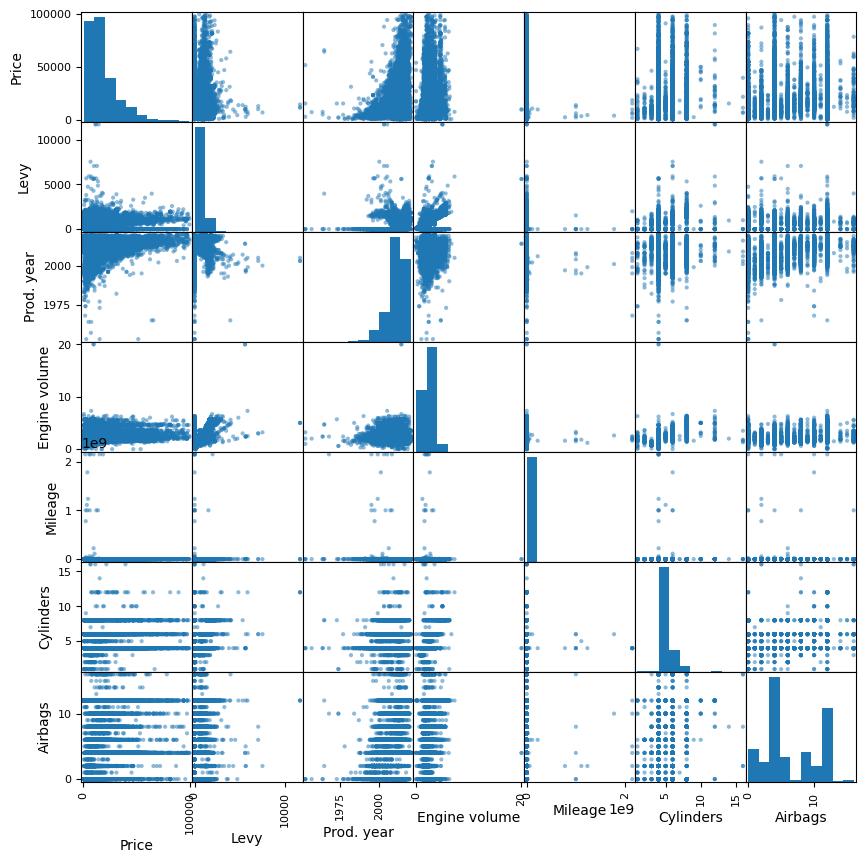

In [179]:
pd.plotting.scatter_matrix(
    df[["Price", "Levy", "Prod. year", "Engine volume", "Mileage", "Cylinders", "Airbags"]],
    figsize=(10,10)
);

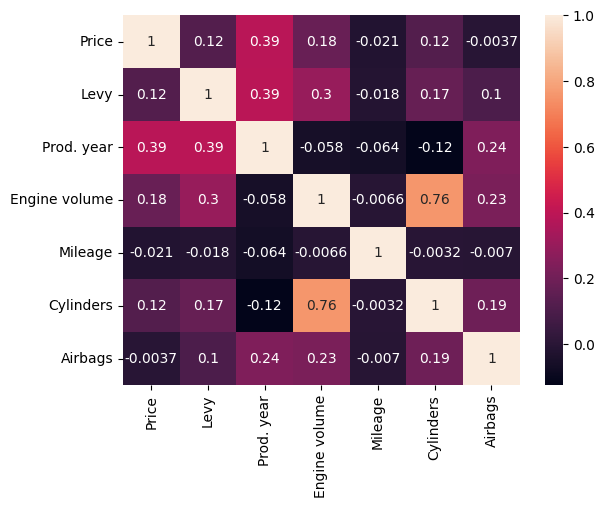

In [182]:
sns.heatmap(df[["Price", "Levy", "Prod. year", "Engine volume", "Mileage", "Cylinders", "Airbags"]].corr(), annot=True);

Сильной линейной зависимости нет. На графиках зависимость есть, не линейная.
Engine volume и Сylinders линейно зависимы стоит ли удалить один из них?
Как оценивать связи с бинарными значениями?